In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal
from skimage import exposure

from ipywidgets import interact, IntSlider

from tapeAnalyst import gel_processing as gp

%matplotlib inline

In [87]:
dfSample = pd.read_csv('../data/JH_sample.csv', encoding='ISO-8859-1')
dfSample.columns = ['wellID', 'conc', 'description', 'alert', 'notes']

In [88]:
gel = gp.TapeStationGel('../data/JH_gel.png', dfSample)

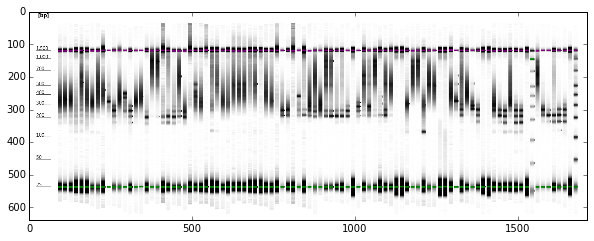

In [89]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(gel.colorGel)

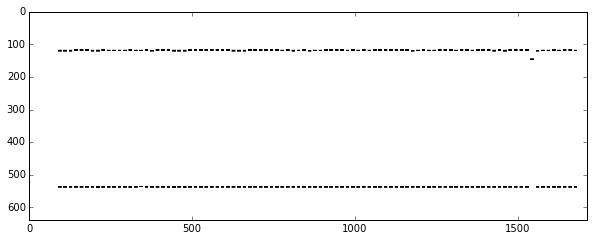

In [90]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(gel.dyeGel, cmap='Greys')

In [91]:
interpMW = gp.interpMW(gel.ladders)

AttributeError: 'module' object has no attribute 'interpMW'

In [ ]:
num = len(gel.lanes)

In [ ]:
def peakCall(num, od, gain):
    lane = gel.lanes[num]
    frontmid = int(np.ceil(np.mean([lane.dyeFrontStart, lane.dyeFrontEnd])))
    endmid = int(np.ceil(np.mean([lane.dyeEndStart, lane.dyeEndEnd])))
    
    ladj = exposure.adjust_sigmoid(lane.lane, cutoff=0.5, gain=gain)

    global laneMean
    laneMean = ladj.max(axis=1)

    laneMean = signal.convolve(laneMean, signal.hamming(5))
    laneMean[frontmid] = laneMean[frontmid] + 2
    laneMean[frontmid+1:] = 0
    laneMean[endmid] = laneMean[endmid] + 2
    laneMean[:endmid-1] = 0
    laneMean[laneMean < 0.2] = 0

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(ladj, cmap='Greys')
    ax2.plot(laneMean)
    peaks = signal.argrelmax(laneMean, order=od)[0]
    print(peaks)
    for peak in peaks:
        ax2.axvline(peak)

In [ ]:
interact(peakCall, num=IntSlider(7, min=0, max=90), od=IntSlider(7, min=1, max=100, step=2), gain=IntSlider(7, min=1, max=100, step=2))

In [98]:
bob = list()

In [99]:
bob.append('OK')

In [101]:
if not 'NODYEEND' in bob and not 'NODYEFRONT' in bob:
    print('yes')

yes
